

> MOUNT DRIVE



In [24]:
from google.colab import drive
drive.mount('/gdrive')
#drive.mount('/content/drive/')
%cd "/gdrive/MyDrive/AN2DL - Timeseries Challenge"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/AN2DL - Timeseries Challenge


>IMPORT LIBRARIES AND SET SEED

In [25]:
#Libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [26]:
# Random seed for reproducibility
seed = 420

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

> IMPORT AND INSPECT DATASET

In [27]:
dataset = pd.read_csv('Training.csv')
print('Timeseries shape:\n', dataset.shape)

Timeseries shape:
 (68528, 7)


In [28]:
#Check the start of the dataset
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [29]:
#Main characteristics 
dataset.describe().transpose()
#There are no missing values (apparently! see after)

,count,mean,std,min,25%,50%,75%,max
Sponginess,68528.0,6.094102,1.941639,-0.972080,4.79144,5.702780,7.067300,15.106680
Wonder level,68528.0,4.695539,3.374224,-8.450380,2.22342,4.668600,7.115440,18.122899
Crunchiness,68528.0,13.337485,11.703203,-37.581721,10.67282,15.676059,20.568080,41.138801
Loudness on impact,68528.0,2.448660,3.001798,-9.028060,0.46880,2.533840,4.656980,14.035980
Meme creativity,68528.0,2.407010,0.994063,-1.275860,2.11220,2.618500,3.021880,6.056360
Soap slipperiness,68528.0,23.237929,14.298260,-6.006860,12.56024,20.151420,31.245199,77.371620
Hype root,68528.0,8.231283,11.285101,-42.769221,6.60416,10.968300,15.334100,31.024420


In [30]:
#Correlation 
dataset.corr()
#Crunchiness and Hype root are 99% correlated!
#Wonder level and Loudness on impact are 93% correlated!
#We could consider removing redundant information after

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
Sponginess,1.000000,0.253002,0.297509,0.121744,0.331200,0.127885,0.183141
Wonder level,0.253002,1.000000,0.119078,0.930254,0.367438,0.237021,0.074392
Crunchiness,0.297509,0.119078,1.000000,0.067477,0.029108,0.061539,0.987209
Loudness on impact,0.121744,0.930254,0.067477,1.000000,0.056184,0.229336,0.048806
Meme creativity,0.331200,0.367438,0.029108,0.056184,1.000000,0.078168,-0.040596
Soap slipperiness,0.127885,0.237021,0.061539,0.229336,0.078168,1.000000,0.050996
Hype root,0.183141,0.074392,0.987209,0.048806,-0.040596,0.050996,1.000000


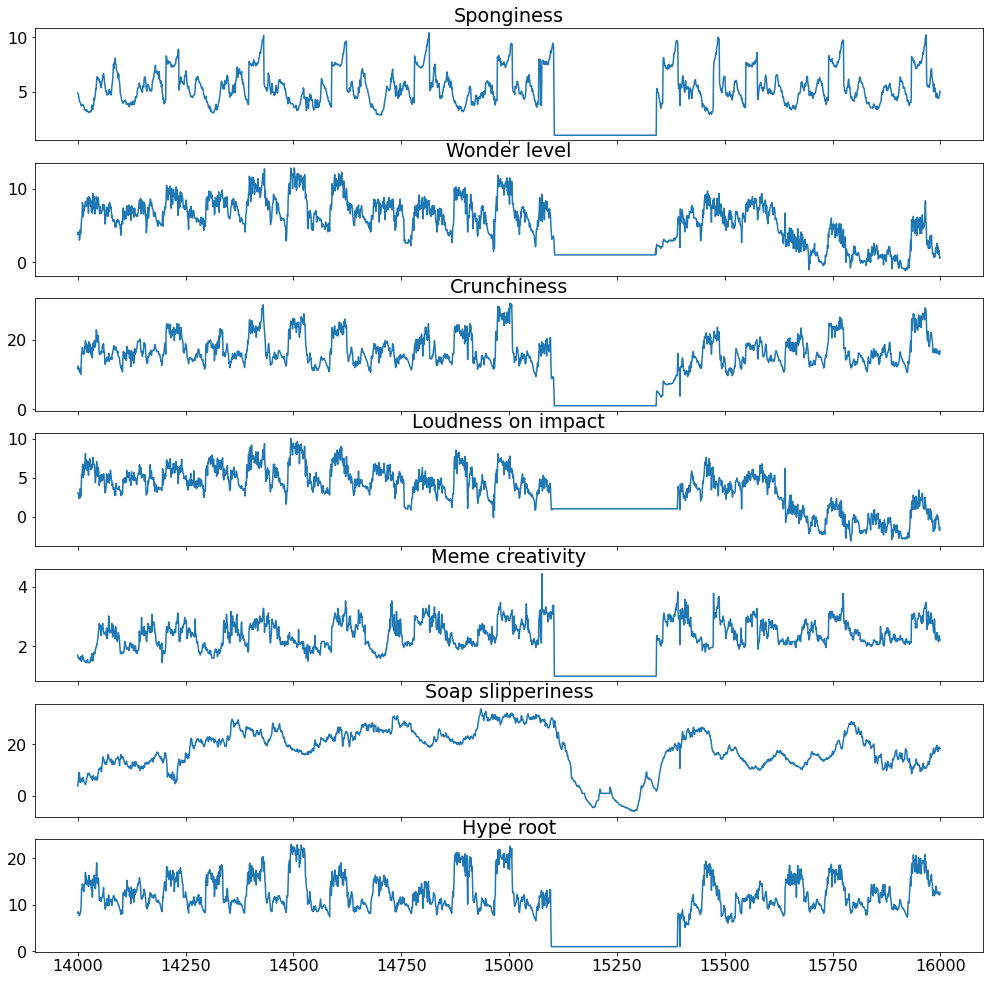

In [31]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset[14000:16000], dataset.columns)

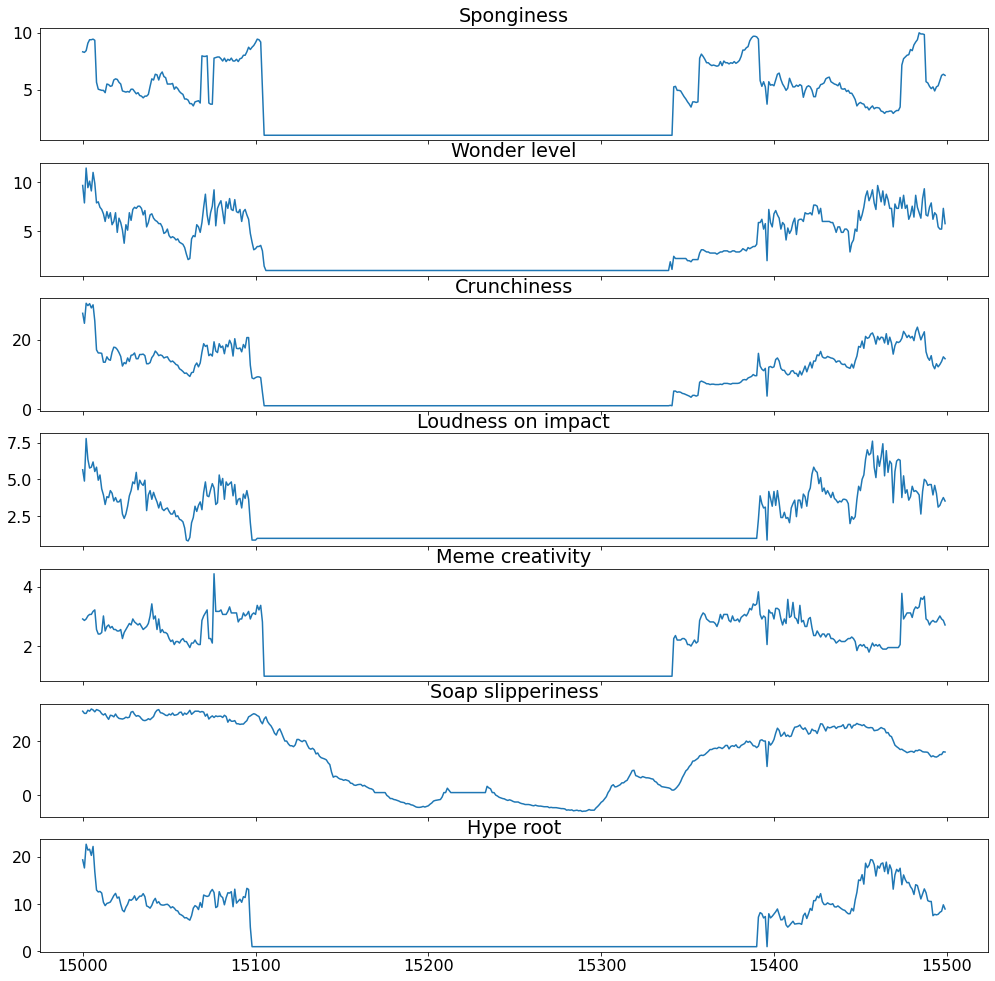

In [32]:
#We notice that there are certain parts were most of the dataset seems constant --> let's investigate
#For example:
inspect_dataframe(dataset[15000:15500], dataset.columns)
#dataset[15104:15344]

In [33]:
# To find all sections with this behavior we loop through the dataset and check where the variance is suspiciously low
step = 50
epsilon = 0.1  # a small value much less than the normal variance of each timeseries
pos_list = []
for i in range(0,dataset.shape[0],step):
  datastep = dataset[i:i+step]
  if (sum(datastep.var() < epsilon) >= 6):  # If all true then the sum is 7, 6 is for safe measure
    pos_list.append(i)
print(pos_list)

[2900, 5900, 11750, 15150, 15200, 15250, 17600, 20550, 26250, 32100, 37950, 40900, 46750, 46800, 52650, 55600, 61250, 67150]


In [34]:
# Find the exact intervals
precise_pos_list = []
for i,v in enumerate(pos_list):
  repeated_value = dataset.iloc[v]
  lower_index = v
  while sum(dataset.iloc[lower_index] == repeated_value)>=6:
    lower_index=lower_index-1
  upper_index = v
  while sum(dataset.iloc[upper_index] == repeated_value)>=6:
    upper_index=upper_index+1
  precise_pos_list.append([lower_index,upper_index])
print(precise_pos_list)

[[2878, 2976], [5854, 5952], [11710, 11808], [15105, 15340], [15105, 15340], [15105, 15340], [17566, 17664], [20542, 20640], [26206, 26304], [32062, 32160], [37918, 38016], [40894, 40992], [46749, 46751], [46750, 46848], [52606, 52704], [55582, 55680], [61246, 61344], [67102, 67200]]


In [35]:
#save list without repeated intervals
precise_pos_list = [[2878, 2976], [5854, 5952], [11710, 11808], [15105, 15340], [17566, 17664], [20542, 20640], [26206, 26304], [32062, 32160], [37918, 38016], [40894, 40992], [46749, 46848], [52606, 52704], [55582, 55680], [61246, 61344], [67102, 67200]]

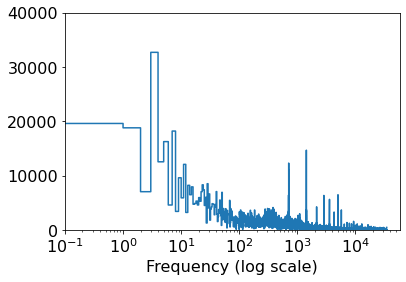

In [36]:
#Data augmentation - Extract periodical behavior
#EXAMPLE
df= dataset
fft = tf.signal.rfft(df['Sponginess'])
f_per_dataset = np.arange(0, len(fft))

plt.step(f_per_dataset, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
_ = plt.xlabel('Frequency (log scale)')

In [37]:
#Identify the peak frequencies for each timeseries
df= dataset
imp_freq = []
min_freq_considered = 4
local_freq_size = 10;
for c in df.columns:
  print(c)
  fft = tf.signal.rfft(df[c])
  fft = np.abs(fft)
  local_freq = {}  #this will be a map storing freq and relative value in the fft
  min_val = float('inf')
  min_val_freq = float('inf')
  for i in range(min_freq_considered,local_freq_size + min_freq_considered):
    local_freq[i]=fft[i];  #store the first local_n_freq
    if fft[i]<min_val:
      min_val = fft[i]
      min_val_freq = i
  #we want to keep the top frequencies of each time series
  for i in range(local_freq_size + min_freq_considered,len(fft)):
    if fft[i]>min_val:
          # erase freq with min val
          local_freq.pop(min_val_freq)
          # add new value
          local_freq[i]=fft[i]
          #compute new minimum
          min_val = float('inf')
          for i,(k,v) in enumerate(local_freq.items()):
            if v<min_val:
              min_val = v
              min_val_freq = k
  for i,(k,V) in enumerate(local_freq.items()):
            print(k)
  print( " ")
  

Sponginess
4
5
6
8
10
12
29
710
718
1428
 
Wonder level
4
8
9
10
13
15
26
43
714
1428
 
Crunchiness
4
6
709
710
712
713
714
716
1427
1428
 
Loudness on impact
4
6
8
9
10
13
16
714
715
1428
 
Meme creativity
6
7
8
9
12
13
15
24
43
714
 
Soap slipperiness
4
5
6
7
8
10
12
35
63
714
 
Hype root
4
710
712
713
714
716
717
1427
1428
2141
 


In [38]:
# Save the most common frequencies
imp_freq = [8, 9, 10, 12, 13, 710, 714, 718, 1428]
#imp_freq_extended = [4, 8, 9, 10, 12, 13, 26, 35, 43, 64, 710, 714, 718, 1428, 2141] not used, didn't yield better results
# Add sinusoidal functions as new features
for i in imp_freq:
  dataset['Sin_freq_'+str(i)] = np.sin(np.arange(len(dataset)) * (2 * np.pi / i))

In [39]:
#Try to separate the sponginess values DISCARDED OPTION
# sponginess = dataset["Sponginess"]
# a = np.array(sponginess>8)*1
# dataset['Sponginess_1he_gr8er'] = a
# b = np.array(sponginess<8)*1
# dataset['Sponginess_1he_l8wer'] = b

>SPLIT THE DATASET

(64000, 16) (4528, 16)
X_max =  Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
Sin_freq_8             1.000000
Sin_freq_9             0.984808
Sin_freq_10            0.951057
Sin_freq_12            1.000000
Sin_freq_13            0.992709
Sin_freq_710           0.999990
Sin_freq_714           0.999990
Sin_freq_718           0.999990
Sin_freq_1428          1.000000
dtype: float64
X_min =  Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
Sin_freq_8            -1.000000
Sin_freq_9            -0.984808
Sin_freq_10           -0.951057
Sin_freq_12           -1.000000
Sin_freq_13           -0.992709
Sin_freq_710          -0.999990
Sin_freq_714    

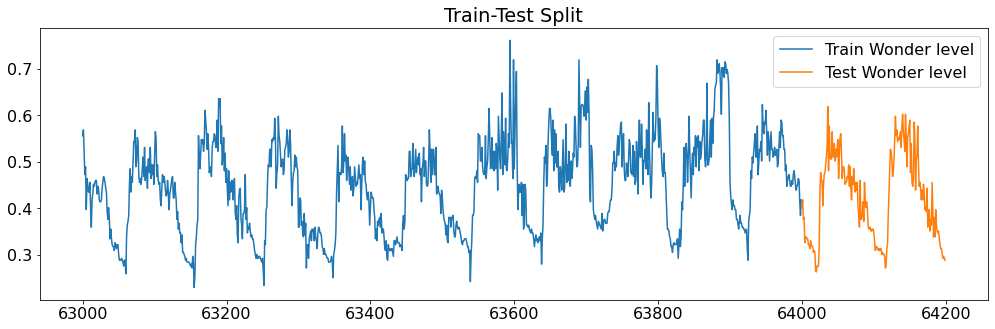

In [40]:
test_size = 4528  
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()
print("X_max = ", X_max)
print("X_min = ", X_min)

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
cl = 1
plt.plot(X_train_raw.iloc[-1000:,cl], label='Train '+ dataset.columns[cl])
plt.plot(X_test_raw.iloc[:200,cl], label='Test '+ dataset.columns[cl])
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [41]:
window = 1000  #values needed for prediction
stride = 10  # stride with which we sample through the dataset
target_labels = dataset.columns[:7]    # multivariate forecasting
telescope = 864    # for the first phase we need to predict 864 values in the future

In [42]:
def build_sequences(df, target_labels=['pollution'], window=2000, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [43]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6214, 1000, 16), (6214, 864, 7), (314, 1000, 16), (314, 864, 7))

>DATA CLEANING

In [44]:
#eliminate batches containing constant values
train_val_batch_length = window + telescope
pos = 0
pos_remove = []
for idx in range(0, X_train.shape[0]):
    i = idx*stride
    if i > precise_pos_list[pos][1]:
      pos = pos + 1
    if (i+train_val_batch_length <= precise_pos_list[pos][1] and i+train_val_batch_length >= precise_pos_list[pos][0]) or \
    (i >= precise_pos_list[pos][0] and i <= precise_pos_list[pos][1]) or \
    (i +train_val_batch_length >= precise_pos_list[pos][1] and i <= precise_pos_list[pos][0]):
      pos_remove.append(idx)

print(pos_remove)
print(len(pos_remove))

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 399, 400, 401, 402,

In [45]:
X_train = np.delete(X_train,pos_remove,0)
y_train = np.delete(y_train,pos_remove,0)
print(X_train.shape,y_train.shape)

(3451, 1000, 16) (3451, 864, 7)


In [46]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

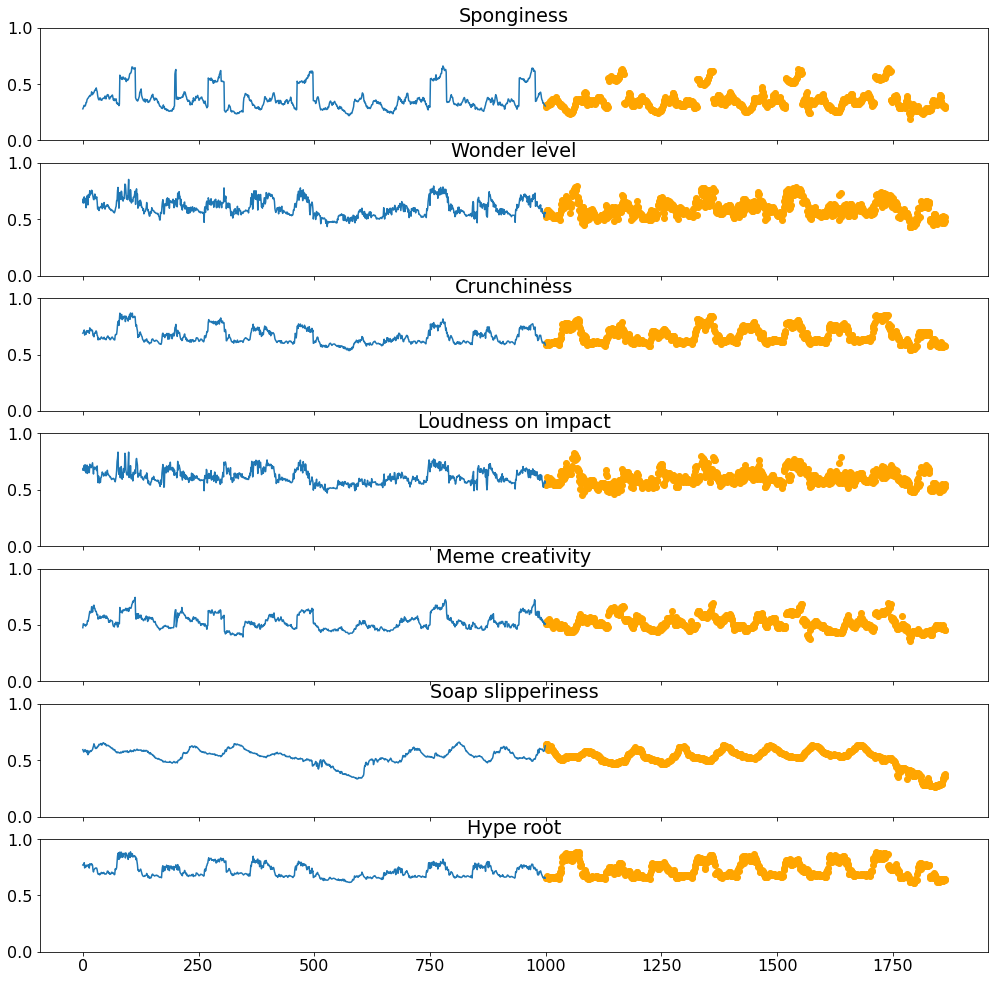

In [47]:
inspect_multivariate(X_train, y_train, target_labels, telescope,290)

In [48]:
# Correlation: remove crunchiness and wonder level from training set, redundant
X_train = np.delete(X_train,[1,2],2) 
print(X_train.shape,y_train.shape)

(3451, 1000, 14) (3451, 864, 7)


>BUILD AND TRAIN THE MODEL

In [49]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [50]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    model = tfk.Sequential()
    model.add(tfkl.LSTM(512, input_shape=(input_shape[0],input_shape[1])))
    model.add(tfkl.Dense(8000, activation='relu'))
    model.add(tfkl.Dense(7000, activation='relu'))
    model.add(tfkl.Dense(output_shape[-2]*output_shape[-1], activation='sigmoid'))

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]

    model.add(tfkl.Reshape((output_shape[-2],output_shape[-1])))

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1079296   
                                                                 
 dense (Dense)               (None, 8000)              4104000   
                                                                 
 dense_1 (Dense)             (None, 7000)              56007000  
                                                                 
 dense_2 (Dense)             (None, 6048)              42342048  
                                                                 
 reshape (Reshape)           (None, 864, 7)            0         
                                                                 
Total params: 103,532,344
Trainable params: 103,532,344
Non-trainable params: 0
_________________________________________________________________


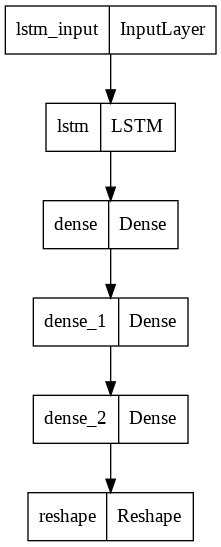

In [51]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [52]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
49/49 [==============================] - 16s 219ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1378 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 10s 207ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 10s 210ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256 - lr: 0.0010
Epoch 4/200
49/49 [==============================] - 10s 214ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 11s 216ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183 - lr: 0.0010
Epoch 6/200
49/49 [==============================] - 11s 218ms/st

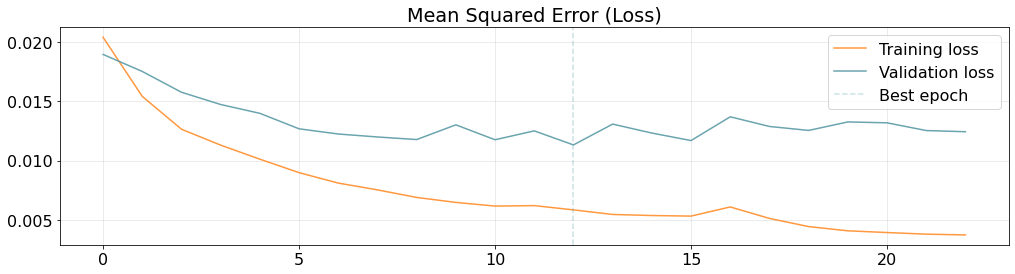

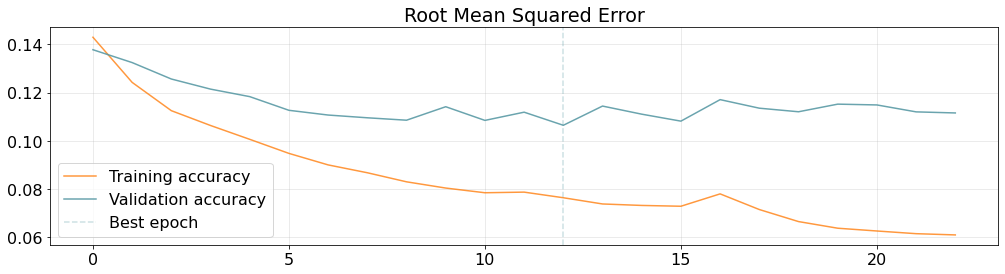

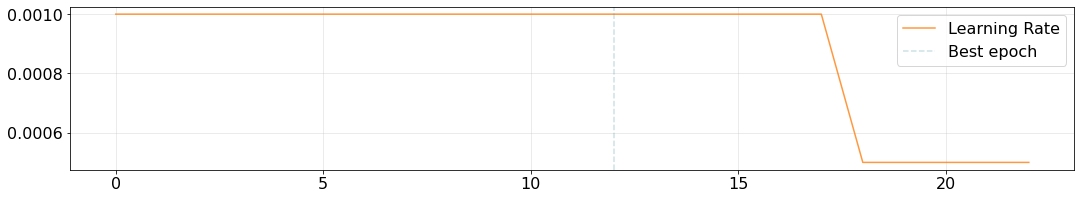

In [53]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
metric = 'root_mean_squared_error'
val_metric = 'val_root_mean_squared_error'
plt.plot(history[metric], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history[val_metric], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [54]:
#model.save('TimeseriesModel_v1.7_filled_values_from1.5')

TEST SET


In [55]:
#model = tfk.models.load_model('TimeseriesModel_v1.5')

In [56]:
# Predict the test set 
predictions = model.predict(np.delete(X_test,[1,2],2))
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(314, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.012012344>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.080060765>)

In [57]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

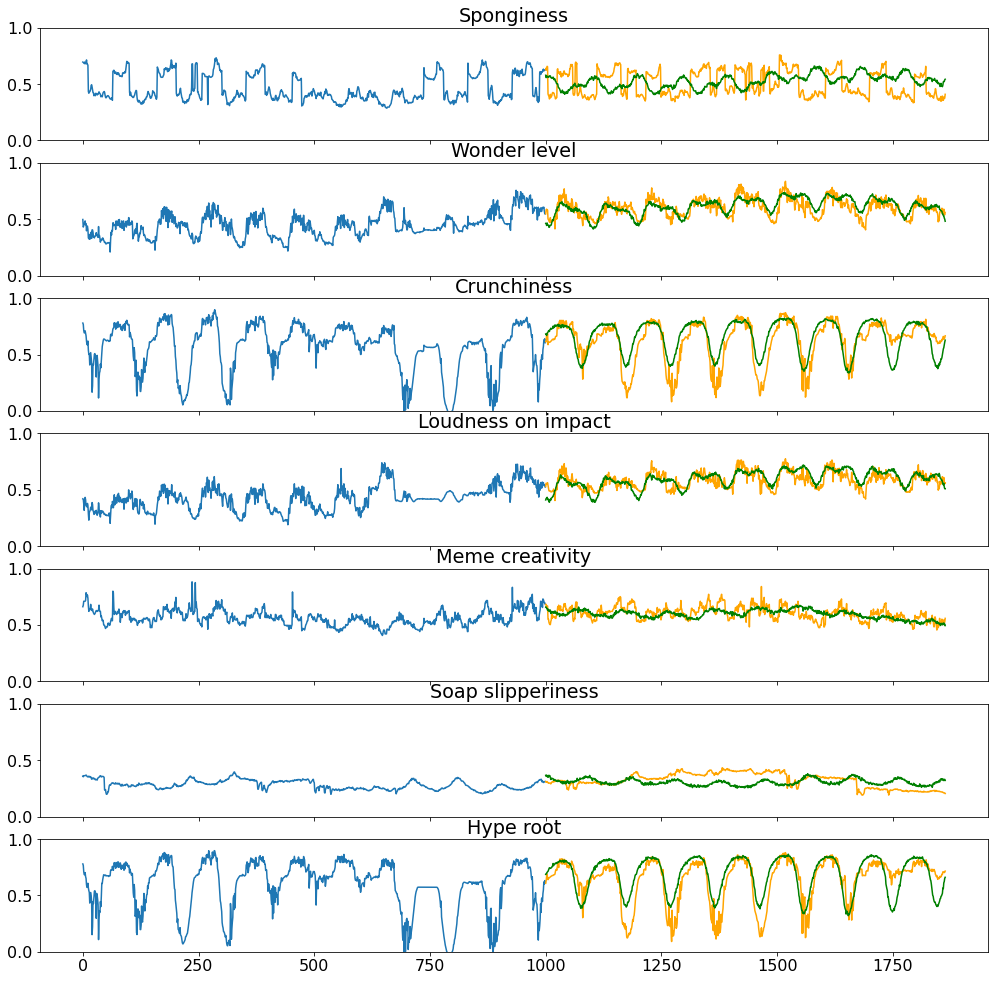

In [58]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

> **END OF THE MODEL - BELOW IS EXTRA** 

> Use the model to fill the constant values in the database

In [ ]:
X_max_2 = pd.Series( {'Sponginess':           15.106680,
'Wonder level':          18.122899,
'Crunchiness':           41.138801,
'Loudness on impact':    14.035980,
'Meme creativity':        6.056360,
'Soap slipperiness':     77.371620,
'Hype root':             31.024420})

X_min_2 = pd.Series( {'Sponginess':           -0.972080,
'Wonder level':          -8.450380,
'Crunchiness':           -37.581721,
'Loudness on impact':    -9.028060,
'Meme creativity':        -1.275860,
'Soap slipperiness':     -6.006860,
'Hype root':             -42.769221})     

In [59]:
dataset = pd.read_csv('Training.csv')
X= tf.convert_to_tensor(dataset)
Y = dataset
Z = dataset #we need this to be the original, we won't touch this
precise_pos_list = [[2878, 2976], [5854, 5952], [11710, 11808], [15105, 15340], [17566, 17664], [20542, 20640], [26206, 26304], [32062, 32160], [37918, 38016], [40894, 40992], [46749, 46848], [52606, 52704], [55582, 55680], [61246, 61344], [67102, 67200]]

# Check here what to write in model.py
X=X.numpy()
len_X = len(X)
imp_freq = [8, 9, 10, 12, 13, 710, 714, 718, 1428]
for i in imp_freq:
    X=np.concatenate((X, np.reshape(np.sin(np.arange(len_X) * (2 * np.pi / i)),[len_X,1])),axis=1)
X = tf.constant(X)
X = (X-X_min)/(X_max-X_min)
X=tf.expand_dims(X,axis=0)
X = np.delete(X,[1,2],2)

Y=  pd.read_csv('Training.csv')
#inspect_dataframe(Y[15000:15500], Y.columns[:7])
for i,v in enumerate(precise_pos_list):
  #print(v[0])  #current position it's working on
  local_X = X[:,v[0]-1000:v[0],:]

  out = model.predict(local_X)
  out = tf.squeeze(out)
  out = out*(X_max_2-X_min_2) + X_min_2  #shape of [864,7]

  size_needed = v[1]-v[0]
  sub_array = out[:size_needed]
  for i in range(size_needed):
    for j in range(7):
      if (Z.iloc[int(v[0]+size_needed/3):int(v[1]-size_needed/3),j].var() > 0.6):
        continue # if values are not constant don't overwrite
      Y.iloc[v[0]+i][j] = sub_array[i][j]



NameError: ignored

In [ ]:
#Check how the dataset is looking now
inspect_dataframe(Y[15000:15500], Y.columns[:7])
#Not perfect but it is a start!
#Now we could re-train on this new dataset!

>SUBMIT RESULTS ON CODALAB

In [ ]:
X_max = pd.Series( {'Sponginess':           15.106680,
'Wonder level':          18.122899,
'Crunchiness':           41.138801,
'Loudness on impact':    14.035980,
'Meme creativity':        6.056360,
'Soap slipperiness':     77.371620,
'Hype root':             31.024420,
'Sin_freq_8':             1.000000,
'Sin_freq_9':             0.984808,
'Sin_freq_10':            0.951057,
'Sin_freq_12':            1.000000,
'Sin_freq_13':            0.992709,
'Sin_freq_710':           0.999990,
'Sin_freq_714':           0.999990,
'Sin_freq_718':           0.999990,
'Sin_freq_1428':          1.000000})

X_min = pd.Series( {'Sponginess':           -0.972080,
'Wonder level':          -8.450380,
'Crunchiness':           -37.581721,
'Loudness on impact':    -9.028060,
'Meme creativity':        -1.275860,
'Soap slipperiness':     -6.006860,
'Hype root':             -42.769221,
'Sin_freq_8':             -1.000000,
'Sin_freq_9':             -0.984808,
'Sin_freq_10':            -0.951057,
'Sin_freq_12':            -1.000000,
'Sin_freq_13':            -0.992709,
'Sin_freq_710':           -0.999990,
'Sin_freq_714':           -0.999990,
'Sin_freq_718':           -0.999990,
'Sin_freq_1428':          -1.000000}) 

In [ ]:
X_max_2 = pd.Series( {'Sponginess':           15.106680,
'Wonder level':          18.122899,
'Crunchiness':           41.138801,
'Loudness on impact':    14.035980,
'Meme creativity':        6.056360,
'Soap slipperiness':     77.371620,
'Hype root':             31.024420})

X_min_2 = pd.Series( {'Sponginess':           -0.972080,
'Wonder level':          -8.450380,
'Crunchiness':           -37.581721,
'Loudness on impact':    -9.028060,
'Meme creativity':        -1.275860,
'Soap slipperiness':     -6.006860,
'Hype root':             -42.769221})     

In [ ]:
dataset = pd.read_csv('Training.csv')
X= tf.convert_to_tensor(dataset)

# Check here what to write in model.py
X=X.numpy()
len_X = len(X)
imp_freq = [8, 9, 10, 12, 13, 710, 714, 718, 1428]
for i in imp_freq:
    X=np.concatenate((X, np.reshape(np.sin(np.arange(len_X) * (2 * np.pi / i)),[len_X,1])),axis=1)
sponginess = X[:,1]
X = np.concatenate((X,np.reshape(np.array(sponginess>8)*1,[len_X,1])),axis=1)
X = np.concatenate((X,np.reshape(np.array(sponginess<8)*1,[len_X,1])),axis=1)
X = X[-1000:]
X = tf.constant(X)
X = (X-X_min)/(X_max-X_min)
X=tf.expand_dims(X,axis=0)
X = np.delete(X,[1,2],2)
out = model.predict(X)
out = tf.squeeze(out)
out = out*(X_max_2-X_min_2) + X_min_2

In [ ]:
#check
out.shape